In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd

import sys
import time
import pickle
import gc
import pathlib
import os

import signac

from scipy import optimize

In [2]:
from monk import nb, prep, pair, render, utils, grid, workflow
import freud

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())

# mpl.rcParams["text.usetex"] = True
# mpl.rcParams["text.latex.preamble"].append(r'\usepackage{xfrac}')

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 11, 'dt': 0.005, 'step_unit': 1000, 'temp_steps': 20, 'equil_time': 40, 'run_time': 10, 'max_alpha_time': 1000, 'alpha_iters': 10, '_status': {}}

0_375
0_450
0_525
0_600
0_675
0_750
0_825
0_900
0_975
1_050
1_125
1_200
1_275
1_350
1_425
1_500
[0.375, 0.45, 0.525, 0.6, 0.675, 0.75, 0.825, 0.9, 0.975, 1.05, 1.125, 1.2, 1.275, 1.35, 1.425, 1.5] [129.99999709427357, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291]
0_375
0_450
0_525
0_600
0_675
0_750
0_825
0_900
0_975
1_050
1_125
1_200
1_275
1_350
1_425
1_500
[0.375, 0.45, 0.525, 0.6, 0.675, 0.75, 0.825, 0.9, 0.975, 1.05, 1.125, 1.2, 1.275, 1.35, 1.425, 1.5] [129.99999709427357, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.9999988824

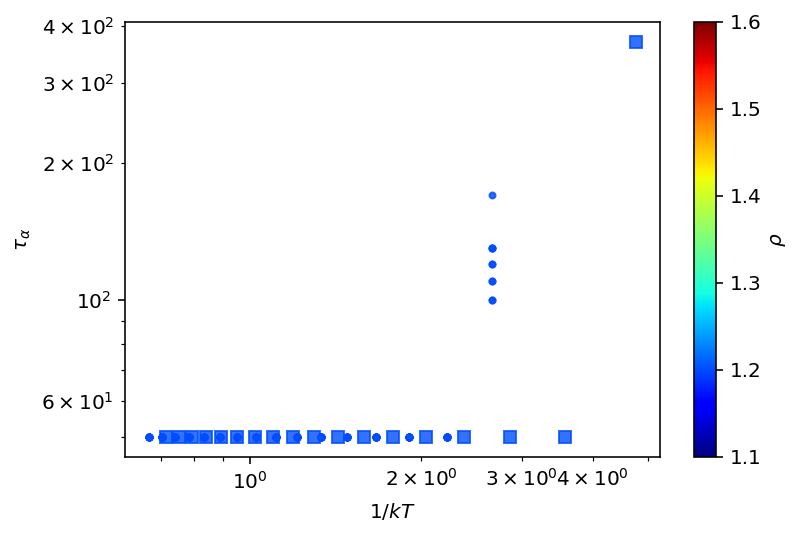

In [4]:

plt.figure()

_alpha = .8

markers = {"KA_LJ": ".", "KA_WCA": "s"}
cmap = cm.jet
norm = colors.Normalize(vmin=1.1, vmax=1.6)

for i, job in enumerate(project):

    # delta = job.sp["delta"]
    # if delta > 0.45:
    #     continue

    marker = markers[job.sp["pot"]]
    col = cmap(norm(job.sp["rho"]))

    with job:
        sims = sorted(glob.glob("quench/equil*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_temp-", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                # print(list(job.data["quench"].keys()))
                print(_temp_str)
                # try:
                if len(job.data[f"quench/temp_{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"quench/temp_{_temp_str}/alphas"][-5:])
                # if alpha < 11:
                #     continue
                D = np.mean(job.data[f"quench/temp_{_temp_str}/Ds"][-5:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                # except:
                #     raise ValueError("No data found")
                
        print(temps, alphas)
        plt.plot(1/np.array(temps), np.array(alphas), marker, color=col, alpha=_alpha)

plt.xlabel(r"$1/kT$")
plt.ylabel(r"$\tau_{\alpha}$")
plt.yscale('log')
plt.xscale('log')
# plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\rho$")
plt.yscale('log')

0 [0.3, 0.337, 0.375, 0.412, 0.45, 0.487, 0.525, 0.562, 0.6, 0.637, 0.675] [2799.999937415123, 245.99999450147152, 96.99999783188105, 34.99999921768904, 18.499999586492777, 9.699999783188105, 9.09999979659915, 6.299999859184027, 5.199999883770943, 4.399999901652336, 3.899999912828207]
1 [0.337, 0.375, 0.412, 0.45, 0.487, 0.525, 0.562, 0.6, 0.637, 0.675] [255.9999942779541, 86.99999805539846, 29.999999329447746, 21.99999950826168, 12.399999722838402, 8.59999980777502, 5.999999865889549, 5.099999886006117, 4.499999899417162, 3.799999915063381]
0 [0.21, 0.245, 0.28, 0.315, 0.35, 0.385, 0.42, 0.455, 0.49] [322.9999927803874, 68.99999845772982, 26.99999939650297, 13.099999707192183, 9.499999787658453, 7.999999821186066, 6.199999861419201, 4.899999890476465, 4.399999901652336]
8 [0.3, 0.337, 0.375, 0.412, 0.45, 0.487, 0.525, 0.562, 0.6, 0.637, 0.675] [2669.9999403208494, 309.99999307096004, 79.99999821186066, 32.99999926239252, 18.999999575316906, 11.099999751895666, 8.299999814480543, 6.599

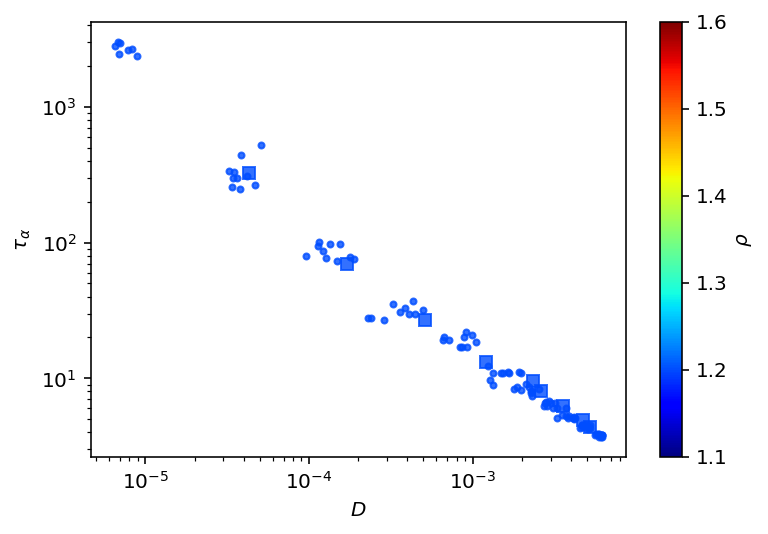

In [9]:

plt.figure()

_alpha = .8

markers = {"KA_LJ": ".", "KA_WCA": "s"}
cmap = cm.jet
norm = colors.Normalize(vmin=1.1, vmax=1.6)

for i, job in enumerate(project):

    # delta = job.sp["delta"]
    # if delta > 0.45:
    #     continue

    marker = markers[job.sp["pot"]]
    col = cmap(norm(job.sp["rho"]))

    with job:
        sims = sorted(glob.glob("fine/equil*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_temp-", ".gsd")

            # print(sim)

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                # print(list(job.data["fine"].keys()))
                # print(_temp_str)
                # try:
                if len(job.data[f"fine/temp_{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"fine/temp_{_temp_str}/alphas"][-5:])
                # if alpha < 1:
                #     continue
                D = np.mean(job.data[f"fine/temp_{_temp_str}/Ds"][-5:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                # except:
                #     raise ValueError("No data found")
                
        print(job.sp["replica"], temps, alphas)
        plt.plot(np.array(Ds), np.array(alphas), marker, color=col, alpha=_alpha)

plt.ylabel(r"$\tau_{\alpha}$")
plt.xlabel(r"$D$")
# plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\rho$")
plt.yscale('log')
plt.xscale('log')

0.300 2799.999937415123
0.337 245.99999450147152
0.375 96.99999783188105
0.412 34.99999921768904
0.450 18.499999586492777
0.487 9.699999783188105
0.525 9.09999979659915
0.562 6.299999859184027
0.600 5.199999883770943
0.337 255.9999942779541
0.375 86.99999805539846
0.412 29.999999329447746
0.450 21.99999950826168
0.487 12.399999722838402
0.525 8.59999980777502
0.562 5.999999865889549
0.600 5.099999886006117
0.210 322.9999927803874
0.245 68.99999845772982
0.280 26.99999939650297
0.315 13.099999707192183
0.350 9.499999787658453
0.385 7.999999821186066
0.420 6.199999861419201
0.300 2669.9999403208494
0.337 309.99999307096004
0.375 79.99999821186066
0.412 32.99999926239252
0.450 18.999999575316906
0.487 11.099999751895666
0.525 8.299999814480543
0.562 6.599999852478504
0.600 5.2999998815357685
0.300 2369.999947026372
0.337 338.99999242275953
0.375 72.99999836832285
0.412 27.99999937415123
0.450 16.899999622255564
0.487 8.999999798834324
0.525 7.399999834597111
0.562 6.199999861419201
0.337 

Text(0, 0.5, '$\\tau_{\\alpha}$')

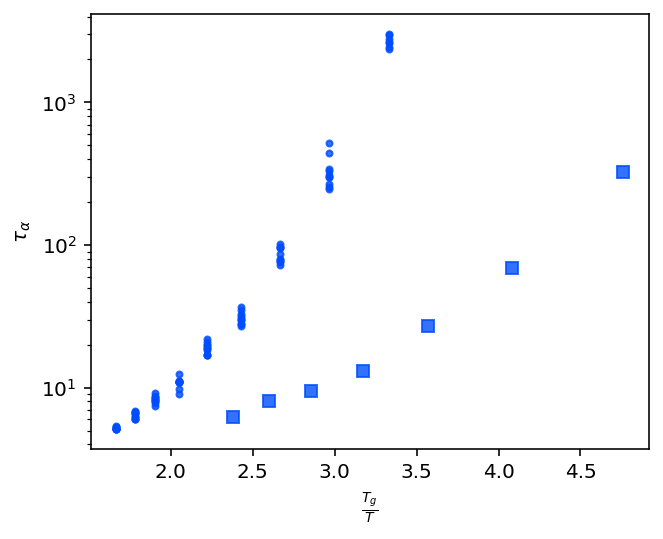

In [6]:
def vft(x, a, b, t):
    return np.log(a * np.exp(b/(x-t)))

plt.figure(figsize=(5,4))

for i, job in enumerate(project):

    marker = markers[job.sp["pot"]]
    col = cmap(norm(job.sp["rho"]))

    with job:
        sims = sorted(glob.glob("fine/equil_*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_temp-", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"fine/temp_{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"fine/temp_{_temp_str}/alphas"][-5:])
                if alpha < 5:
                    continue
                D = np.mean(job.data[f"fine/temp_{_temp_str}/Ds"][-5:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                print(temp_str, alpha)
        
        if len(alphas) == 0:
            continue
        # print(temps, alphas)
        alphas = np.log(np.array(alphas))
        temps = np.array(temps)
        popt, pcov = optimize.curve_fit(vft, temps, alphas, p0=(1, 0.5, np.min(temps)/2), bounds=([0, -0, np.min(temps)/4], [np.inf, np.inf, np.min(temps)]))
        tg = popt[2]
        # tg = np.min(temps)/2
        # print(popt, pcov)
        plt.plot(1/temps, np.exp(alphas) , marker, color=col, alpha=_alpha)

plt.yscale("log")
plt.xlabel(r"$\frac{T_g}{T}$")
plt.ylabel(r"$\tau_{\alpha}$")

KA_LJ
2674.9999402090907
0.19836457263395846
KA_LJ
281.2499937135726
0.1885884623197091
KA_WCA
338.74999242834747
0.12345081002164043
KA_LJ
2899.999935179949
0.19970101618537328
KA_LJ
2049.9999541789293
0.20064566177969148
KA_LJ
264.9999940767884
0.19891324958130724
KA_LJ
2599.9999418854713
0.17912985864615352
KA_LJ
2499.9999441206455
0.19790323038970434
KA_LJ
3112.4999304302037
0.20418799605036095
KA_LJ
308.7499930988997
0.21129421915271243
KA_LJ
2987.4999332241714
0.1902737451703026


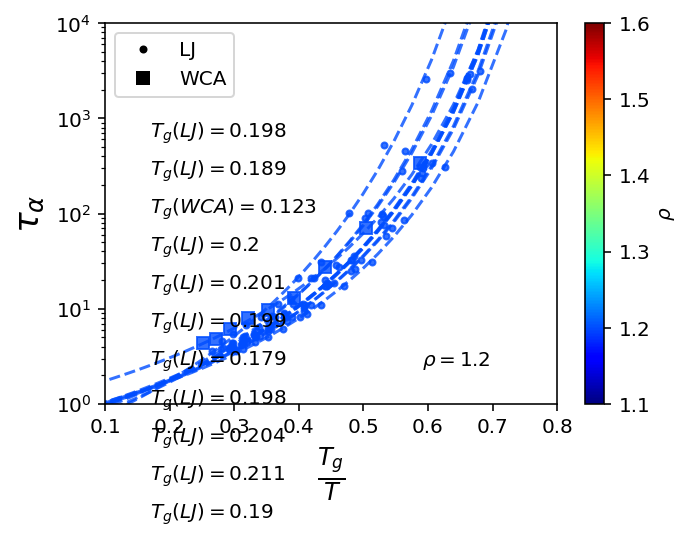

In [7]:
def vft(x, a, b, t):
    return np.log(a * np.exp(b/(x-t)))

plt.figure(figsize=(5,4))

for i, job in enumerate(project):

    pot = job.sp["pot"]
    marker = markers[pot]
    col = cmap(norm(job.sp["rho"]))

    print(job.sp["pot"])

    with job:
        sims = sorted(glob.glob("fine/equil_*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_temp-", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"fine/temp_{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"fine/temp_{_temp_str}/alphas"][-4:])
                if alpha < 2:
                    continue
                D = np.mean(job.data[f"fine/temp_{_temp_str}/Ds"][-4:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                # print(temp_str, alpha)
        
        if len(alphas) == 0:
            continue
        # print(temps, alphas)
        print(np.max(alphas))
        alphas = np.log(np.array(alphas))
        temps = np.array(temps)
        popt, pcov = optimize.curve_fit(vft, temps, alphas, p0=(1, 0.5, np.min(temps)/2), bounds=([0, -0, np.min(temps)/4], [np.inf, np.inf, np.min(temps)]))
        tg = popt[2]
        # tg = np.min(temps)/2
        # print(popt, pcov)
        x = np.linspace(tg*1.3, tg*10.0, 100)
        y = vft(x, *popt)
        # print(job, tg)
        job.data["results/tg"] = tg
        plt.text(0.1, 0.7-i*.1, fr"$T_g({pot[3:]})={tg:.3}$", transform=plt.gca().transAxes)
        with job.data:
            print(job.data["results/tg"])
        plt.plot(tg/x, np.exp(y), "--", color=col, alpha=_alpha)
        plt.plot(tg/temps, np.exp(alphas) , marker, color=col, alpha=_alpha)

plt.yscale("log")
plt.xlabel(r"$\frac{T_g}{T}$", size="xx-large")
plt.ylabel(r"$\tau_{\alpha}$", size="xx-large")

lines = [
    plt.Line2D([0], [0], color='black', lw=0, marker="."),
    plt.Line2D([0], [0], color='black', lw=0, marker="s"),
]
plt.legend(lines, ["LJ", "WCA"], loc="best")
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\rho$")

plt.ylim(1e0, 1e4)
plt.xlim(0.1, 0.8)

plt.text(0.7, 0.1, r"$\rho=1.2$", transform=plt.gca().transAxes)

plt.tight_layout()

plt.savefig("/home/ian/Pictures/monk/2d-esl/angel-plot.png", dpi=200)

In [18]:
job.data["results/tg"]

0.12345081002164043